### Use the Asynchronous Advantage Actor Critic (A3C) Policy Gradient Method to solve Breakout

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import lfilter

import progressbar as pb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp

from torchsummary import summary

In [2]:
env_id = 'BreakoutDeterministic-v4'
env = gym.make(env_id)

In [3]:
env.observation_space

Box(210, 160, 3)

In [4]:
print(f"Actions:{env.action_space}\nMeanings:{env.unwrapped.get_action_meanings()}")

Actions:Discrete(4)
Meanings:['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #convert to GPU if available

## Preprocess Image

In [6]:
## Utils
def preprocess_single_frame(image, bkg_color = np.array([144, 72, 17])):
    """
    Converts an image from RGB channel to B&W channels.
    Also performs downscale to 80x80. Performs normalization.
    @Param:
    1. image: (array_like) input image. shape = (210, 160, 3)
    2. bkg_color: (np.array) standard encoding for brown in RGB with alpha = 0.0
    @Return:
    - img: (array_like) B&W, downscaled, normalized image of shape (80x80)
    """
    img = np.mean(image[35:195:2,::2]-bkg_color, axis=-1)/255.
    return img

#Utils
def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    """
    convert outputs of parallelEnv to inputs to pytorch neural net"""
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color,
                                    axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)

In [7]:
state = env.reset()
for _ in range(20):#skip 20 frames
    frame, _, _, _ = env.step(np.random.randint(0, env.action_space.n))

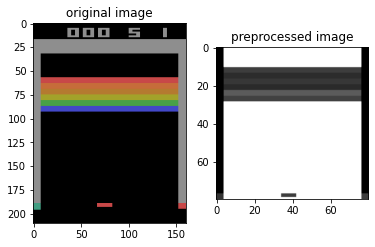

In [8]:
#Plot processed and raw image
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')
# 80 x 80 black and white image
plt.imshow(preprocess_single_frame(frame), cmap='Greys')
plt.show()

# Actor-Critic

![actor critic achitecture](https://www.mdpi.com/energies/energies-09-00725/article_deploy/html/images/energies-09-00725-g001-1024.png)

In [9]:
#DEFINE Constants
GAMMA = 0.99
TAU = 1.0
LR = 1e-3
MAX_EPISODE_LENGTH = 1e8

In [10]:
class ActorCritic(nn.Module):
    def __init__(self, action_size=4, num_frames=2):
        super(ActorCritic, self).__init__()
        self.action_size = action_size
        
        #Define the CNN for Actor & Critic
        self.conv1 = nn.Conv2d(num_frames, 32, 3, stride=2, padding=1) #output = 40x40x32
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1) #output = 20x20x32
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1) #output = 10x10x32
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1) #output = 5x5x32
        
        self.size = 5*5*32 #800

        #FC layer
        self.lstm = nn.LSTMCell(input_size=self.size, hidden_size=512)#lstm cell to prevent vanishing gradients
        
        # Define Actor and Critic network
        # Critic evaluates the state value function, V(π) using TD estimate.
        # Actor evaluates the policy π(a|s) distribution
        
        self.critic_linear, self.actor_linear = nn.Linear(512, 1), nn.Linear(512, self.action_size)
        
    def forward(self, x, hx, cx):
        """
        Peforms one-pass for the Conv layers.
        @Param:
        1. x - shape: (2, 80, 80); 2 stacked frames of 80x80 images
        2. hx - hidden state of the RNN. shape: (1x512)
        3. cx - confidence state of the RNN. shape: (1x512)
        @Return:
        1. critic estimated value, V(π)
        2. actor policy distribution, π(a|s) as logits
        """
        #4 conv nets without max pool layers, simple Relu activation f(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1,self.size) #flatten
        hx, cx = self.lstm(x, (hx, cx)) #dynamic calculation for final confidence & hidden state
        value = self.critic_linear(hx) #CRITIC: calculates estimated state value function, V(π)
        logits = self.actor_linear(hx) #ACTOR:  calculates policy distribution π(a|s)
        
        return logits, value, hx, cx

In [11]:
agent = ActorCritic()

# Optimizer
<p> A critical component to an A3C model is the ability to share parameters across
    multiple agents running asynchronously such that they can collectively learn from
    each other. This is done by the cross-integration (sharing) of gradients across all processes.
</p>

In [12]:
class SharedOptimizer(optim.Adam):
    """Implementation of shared parameter model using Adam optimizer"""
    def __init__(self, params, lr=LR):
        super(SharedOptimizer, self).__init__(params)
        for group in self.param_groups:
            for params in group['params']:
                state = self.state[params]
                state['step'] = 0
                state['exp_avg'] = torch.zeros_like(params.data).share_memory_()
                state['exp_avg_sq'] = torch.zeros_like(params.data).share_memory_()

In [13]:
optimizer = SharedOptimizer(agent.parameters()) #define optimizer (uses Adam, instead of SGD)

## Generalized Advantage Estimator 
<br>
<p>
    Generalized Advantage Estimator (GAE) helps us pick the best value for N-step boostrapping
    by incorporating λ as an added hyper-parameter to tune accordingly that will minimize the
    bias-variance tradeoff.
    <br>
    The derivation can be thought of as <a href="https://danieltakeshi.github.io/2017/04/02/notes-on-the-generalized-advantage-estimation-paper/#the-generalized-advantage-estimator">the exponentially-decayed sum of residual terms.</a>
</p>
<p><strong>See the following <a href="https://arxiv.org/pdf/1506.02438.pdf">derivation</a> for GAE estimator:</strong></p>

![GAE Derivation](https://res.cloudinary.com/crammer/image/upload/v1596251771/Screen_Shot_2020-07-31_at_11.15.47_PM_feuhld.png)

In [14]:
discount = lambda x, gamma: lfilter([1],[1,-gamma],x[::-1])[::-1] # computes discounted reward

In [174]:
def compute_cost(values, log_probs, actions, rewards, gae_lambda=0.5):
    """
    Calculates the policy (actor) and value (critic) loss
    @Param:
    1. values: (tensor) list of V(s) estimator, critic.
    2. log_probs: (tensor) list of π(a|s) softmax output, actor.
    3. actions: (tensor) actions taken from rollout of trajectory.
    4. rewards: (tensor) rewards based on S,A pairs. true values, used to minimize loss.
    5. gae_lambda: (float) [0-1] value of lambda for residual calculation. used in N-step bootstrap.
    @Return:
    - value_loss: (tensor) critic loss.
    - policy_loss: (tensor) actor loss.
    """
    np_values = values.view(-1).data.numpy() #convert torch.tensor to numpy array & flatten/reshape it
    
    #implement GAE
    delta_t = np.asarray(rewards) + GAMMA * (np_values[1:] - np_values[:-1])
    
    log_probs = log_probs.gather(1, torch.tensor(actions).view(-1,1))
    gae = discount(delta_t, GAMMA * TAU)#calculate Generative Advantage Estimate

    #calculate policy_loss = -log( π(a|s) ) * ( R - V(s) )
    policy_loss = -(log_probs.view(-1) * torch.FloatTensor(gae.copy())).sum()
    
    # l2 loss over value estimator
    rewards[-1] += GAMMA * np_values[-1]
    discounted_r = discount(np.asarray(rewards), GAMMA)
    discounted_r = torch.tensor(discounted_r.copy(), dtype=torch.float32)
    
    value_loss = gae_lambda * (discounted_r - values[:-1,0]).pow(2).sum()#set lambda = .5 based on GAE param

    entropy_loss = (-log_probs * torch.exp(log_probs)).sum() # entropy = ∑ -log(π(a|s))*e^(log(π(a|s)))
    #return policy_loss + 0.5 * value_loss - 0.01 * entropy_loss
    return policy_loss + value_loss + entropy_loss #total loss

## Train

In [175]:
# Utils
def sync_models(model, shared_model):
    """
    Syncs the gradients from local model to shared model as a critical part of the A3C algorithm.
    Updates the pointer based reference.
    @param:
    1. model: local model to sync from.
    2. shared_model: global model to sync into.
    """
    for local_param, shared_param in zip(model.parameters(), shared_model.parameters()):
        if(shared_param.grad is not None):
            return
        shared_param.grad = local_param.grad #sync

In [176]:
def get_stacked_frame(reset=True):
    """
    Returns a 1x2x80x80 tensor by concatenating 2 processed frames.
    @Param:
    - reset: (boolean, optional) if True, gets the first 2 frames of the env.
    @return:
    - state: a 1x2x80x80 torch.Tensor
    - frame0: first frame of size 80x80 
    - frame1: second frame of size 80x80 
    """
    frame0 = env.reset()
    frame1,_,_,_ = env.step(1) #fire
    state = preprocess_batch([frame0, frame1]) #1x2x80x80 tensor
    return state, frame0, frame1

In [221]:
def train(shared_model, optimizer=None, num_episode=10, num_steps=20):
    """
    Train A3C agent.
    @Param:
    1. shared_model: instance of ActorCritic class, globally shared model across all parallel agents.
    2. optimizer: instance of SharedOptimizer class, default = None (created as local object).
    3. num_episode: (int) number of episodes to train for.
    4. num_steps: (int) number of forward pass to pass through. default = 20.
    """
    model = ActorCritic() #local model
    
    if(optimizer is None):#create optimizer
        optimizer = SharedOptimizer(shared_model.parameters(), lr=LR)
    
    model.train()#Set the local model in training mode
    
    #Extract stacked frames
    
    state, frame0, frame1 = get_stacked_frame()#1x2x80x80 Tensor
    episode_length = 0
    done = True
    
    #return metrics
    overall_reward = []

    for i in range(1, num_episode+1):
        model.load_state_dict(shared_model.state_dict()) #syncs the shared model with the local model
            
        if done:
            cx, hx = torch.zeros(1, 512), torch.zeros(1, 512)
        else:
            cx = cx.detach()
            hx = hx.detach()
        
        values = []; log_probs = []; rewards = []; actions = []
        for step in range(num_steps):
            episode_length += 1
            logits, value, hx, cx = model(state, hx, cx)
            
            prob = F.softmax(logits, dim=-1)
            log_prob = F.log_softmax(logits, dim=-1)
            
            action = prob.multinomial(num_samples=1).data[0]
            
            state, reward, done, _ = env.step(action.numpy())
            
            #Update frames
            frame0 = frame1
            frame1 = state
            #stack frames to an 1x2x80x80 Tensor
            state = preprocess_batch([frame0, frame1])
            
            #update data
            values.append(value.detach())
            log_probs.append(log_prob)
            rewards.append(reward)
            actions.append(action)
                        
            if done or episode_length > MAX_EPISODE_LENGTH:
                episode_length = 0
                state, frame0, frame1 = get_stacked_frame()#1x2x80x80 Tensor
                break
                
        overall_reward.append(sum(rewards)) #cumulitive reward per episode
    
    
    #Solves broadcasting error
    next_value = torch.zeros(1,1) if done else model(state, hx, cx)[1] #return value
    values.append(next_value.detach())
    
    #compute loss
    loss = compute_cost(torch.cat(values), torch.cat(log_probs), actions, rewards)
    print(f"cost after {num_episode} episodes: {loss}")
    optimizer.zero_grad()#reset gradient
    loss.backward() #perform backprop
    
    #synchronize shared_model with local_model
    sync_models(model, shared_model)
    
    #Perform single forward step
    optimizer.step()
    
    return overall_reward

## Parallelization

In [ ]:
rewards = train(agent, num_episode=10000)

In [ ]:
plt.plot(rewards)